# Homework 3
#### Pierre-Antoine Desplaces, Anaïs Ladoy, Lou Richard

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [2]:
def bars(title, data, xlab, ylab):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize = (15,8))
    ax.set_title(title, fontsize=15, fontweight='bold')
    sns.barplot(x=xlab, y=ylab, data=data, saturation=0.7, errcolor='.7')
    plt.xticks(rotation=90)
    plt.show()

## <b> <font color='purple'>Question 1</font> </b>
<b>Go to the eurostat website and try to find a dataset that includes the european unemployment rates at a recent date.

Use this data to build a Choropleth map which shows the unemployment rate in Europe at a country level. Think about the colors you use, how you decided to split the intervals into data classes or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.</b>

We find the unemployment information under Population and social conditions > Labour Market > Employment and unemployment. We chose to work with the Unemployment rates by sex, age and educational attainment level database found in the LFS - detailed annual survey results.

In [3]:
# Load the file
raw_euro = pd.read_csv('lfsa_urgaed_1_Data.csv')

Looking at the data, we see that we have a lot of unecessary informations. Since we just need the total unemployment rate, not considering the level of education nor the gender, we keep only the 'Total' rows from Sex column, and the 'All ISCED 2011 levels' from the ISCED11 column.

In [4]:
# Remove unecessary rows
raw_euro = raw_euro[raw_euro.SEX == 'Total']
raw_euro = raw_euro[raw_euro.ISCED11 == 'All ISCED 2011 levels ']

We now create the Dataframe we will use keeping only the relevant columns GEO and Value. We then convert our values into a float type.

In [5]:
# Create dataframe with only the relevant columns
df_euro = raw_euro[['GEO', 'Value']].copy()
df_euro.columns = ('Country', 'Unemployment (%)')
# Adjust the index
df_euro.set_index((df_euro.index/15).astype(int), inplace=True)
# Convert the values to float
df_euro['Unemployment (%)'] = df_euro['Unemployment (%)'].astype(float)

We now load the json we will use to display our map.

In [6]:
# Load the json data of the map
euro_geo_path = 'topojson/europe.topojson.json'
euro_geo = json.load(open(euro_geo_path))
# First element of the json
euro_geo['objects']['europe']['geometries'][0]

{'arcs': [[[0, 1, 2]], [[3]], [[4]], [[5, 6, 7, 8, 9, 10], [11]]],
 'id': 'AZ',
 'properties': {'NAME': 'Azerbaijan'},
 'type': 'MultiPolygon'}

When we look at the json, we see that we will have to use the country IDs to match the values from our dataframe to the geometries of the json. We thus create a dictionary mapping the country names to their IDs. We also change the name of Germany and Macedonia in our dataframe in order to match them with the json data. We then add a new column in our dataframe containing the IDs for each country.

In [7]:
# Clean the name of Germany and Macedonia
df_euro.Country = df_euro.Country.replace({'Germany (until 1990 former territory of the FRG)': 'Germany'})
df_euro.Country = df_euro.Country.replace({'Former Yugoslav Republic of Macedonia, the': 'The former Yugoslav Republic of Macedonia'})
# Create a dictionary to convert country names to country IDs
dict_country_id = dict(map(lambda x : (x['properties']['NAME'],x['id']),euro_geo['objects']['europe']['geometries']))
# Adding a new column with country IDs
df_euro['Country ID'] = df_euro.Country.map(lambda x : dict_country_id[x])
# Resulting dataframe
df_euro.head()

,Country,Unemployment (%),Country ID
0,Belgium,7.8,BE
1,Bulgaria,7.6,BG
2,Czech Republic,4.0,CZ
3,Denmark,6.2,DK
4,Germany,4.1,DE


To get a better idea of the repartition of the rates, we first display the values in a bar charts.

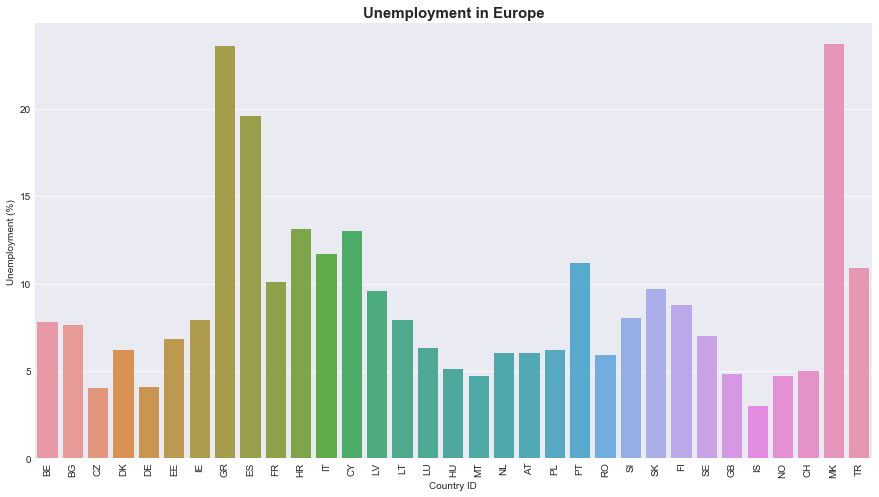

In [8]:
bars("Unemployment in Europe", df_euro, 'Country ID', 'Unemployment (%)')

We now create our map. To define the threshold_scale, we use the mean and the standard deviation of our values. We divide them according to their distance to the mean in terms of the standard deviation.

In [9]:
# Construct the threshold 
mean = df_euro['Unemployment (%)'].mean()
std = df_euro['Unemployment (%)'].std()
min_rate = df_euro['Unemployment (%)'].min()
max_rate = df_euro['Unemployment (%)'].max()

def dist_std(x) :
    return mean + x*std

threshold = [min_rate,dist_std(-1),dist_std(0),dist_std(1),dist_std(2),max_rate]

# Display the visualization map
m_euro = folium.Map([54,15], zoom_start=4)
m_euro.choropleth(
    geo_data = euro_geo,
    data=df_euro,
    columns=['Country ID', 'Unemployment (%)'],
    key_on='feature.id',
    topojson='objects.europe',
    fill_color = 'OrRd', fill_opacity=0.5, line_opacity=0.2,
    legend_name="Unemployment in Europe (in % of population)",
    threshold_scale = threshold
    )
m_euro.save("m_euro.html")

[Click here for the map](m_euro.html)

The countries with no color are those for which we don't have unemployment informations from Eurostat.

Looking at the map, we observe that three countries stand out : Spain, Macedonia and Greece. They have the highest unemployment rate. Countries with high unemployment rate are mostly mediterranean countries : France, Italy, Turkey. 

If we look at Switzerland, we see that it belongs to countries with a quite low unemployment rate.

## <font color='purple'>Question 2</font> 
<b>Go to the amstat website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

HINT Go to the details tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through.
Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.</b>

The unemployement rates of swiss cantons are downloadable through the amstat website (https://www.amstat.ch/v2/index.jsp) according several options we can specify (specific period, geographic level, economic or social attributes, ...).  
We choose to download the latest data that were available, corresponding to the **unemployement rates for September 2017 at a canton level**.


We choose to download five variables that characterize the unemployment in Switzerland : 
- *Unemployment rate (Taux de chômage)* : Registered unemployed / Active population [%]
- *Youth unemployment rate (Taux de chômage des jeunes)* : Registered unemployed aging from 15 to 24 years old / Active population (15-24 y/o) [%]
- *Registered unemployed (Chômeurs inscrits)* : Registered unemployed people that are looking for a job
- *Registered job seekers that are not unemployed* : Registered job seekers that already have a job and are looking for a new one
- *Job seekers (Demandeurs d'emplois)* : Registered unemployed + Registered job seekers that are not unemployed

The goal in this exercise is to show how the choice of metrics to define unemployment can lead to very different interpretations.  
We will first plot a chloropleth map representing the unemployment rate as it is defined by the Swiss confederation at a canton level. Then, we will plot a second chloropleth map representing this time all the job seekers (both the unemployed and the ones who have already a job and are searching for a new one).  
Finally, we will zoom on the particular case of youth unemployment as it can be used as an indicator of the economic situation of a country and it is often considered as a priority for the state.

In [10]:
# Load the amstat datas
amstat_unemp_rate=pd.read_csv('amstat_taux_chomage.csv',sep=',',skipfooter=1,thousands="'",encoding='utf-16',engine='python')
# Remove the first column
amstat_unemp_rate.drop(amstat_unemp_rate.columns[0],axis=1,inplace=True)

In [11]:
amstat_unemp_rate.dtypes

Canton                               object
Taux de chômage                     float64
Taux de chômage des jeunes          float64
Chômeurs inscrits                     int64
Demandeurs d'emploi                   int64
Demandeurs d'emploi non chômeurs      int64
dtype: object

In order to plot the second chloropleth map (unemployment rate including the job seekers who have already a job but looking for a new one), we need to compute this new rate and add it to our dataframe.  
The rate is defined as follow :

*Unemployment rate (all job seekers)* : Job seekers / Active population

The active population per canton is not provided in the amstat website so we used the unemployment rate (Registered unemployed / Active population) to compute this metric.

In [12]:
amstat_unemp_rate["Taux de demandeurs d'emplois"]=amstat_unemp_rate["Demandeurs d'emploi"]*amstat_unemp_rate['Taux de chômage']/amstat_unemp_rate['Chômeurs inscrits']
amstat_unemp_rate.sort_values("Taux de demandeurs d'emplois")

,Canton,Taux de chômage,Taux de chômage des jeunes,Chômeurs inscrits,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs,Taux de demandeurs d'emplois
15,Appenzell Rhodes-Intérieures,0.7,1.0,62,102,40,1.151613
3,Uri,0.6,0.5,112,257,145,1.376786
5,Obwald,0.7,0.7,153,319,166,1.459477
6,Nidwald,1.0,0.9,248,436,188,1.758065
17,Grisons,1.1,1.4,1166,2590,1424,2.443396
4,Schwyz,1.7,1.6,1455,2229,774,2.604330
14,Appenzell Rhodes-Extérieures,1.7,1.5,523,866,343,2.814914
2,Lucerne,1.7,2.1,3885,6756,2871,2.956293
7,Glaris,1.8,1.8,416,713,297,3.085096
1,Berne,2.4,2.8,13658,18385,4727,3.230634


The territorial limits of the swiss cantons are already provided in a TopoJSON file and it will be used as an overlay to create our chloropleth map.   


We need to associate the parameters we want to visualize (rates at canton level) with the geographic entities present in the TopoJSON file (canton id). If we inspect our TopoJSON file, we can see that the object id are the canton codes (ZH, BE, ...) and this information is not present in our dataframe. Thus, the first step is to extract this information from the JSON file and add it as a new column to our data.

In [13]:
# Load the TopoJSON file
swiss_cantons=json.load(open('./topojson/ch-cantons.topojson.json'))
# Create a list with the corresponding code (id) for each canton
cantons_id=[(i['properties']['name'],i['id']) for i in swiss_cantons['objects']['cantons']['geometries']]

In [14]:
cantons_id=pd.DataFrame(cantons_id,columns=['Canton','Code'])
cantons_id.head()

,Canton,Code
0,Zürich,ZH
1,Bern/Berne,BE
2,Luzern,LU
3,Uri,UR
4,Schwyz,SZ


We notice that the swiss cantons names in our dataframe and in the TopoJSON file are really different as the names in the TopoJSON are expressed in the official language for each canton. 
Fortunately, we can see that the cantons are in the same order in both our dataframe and the TopoJSON, we can thus match the canton code according the index.

In [15]:
# Adding a new column with country IDs
amstat_unemp_rate = amstat_unemp_rate.merge(cantons_id[['Code']],left_index=True,right_index=True)

The first cloropleth map is a visualization of the unemployment rate in the Swiss cantons for the month of September 2017 according to the definition of the Swiss Confederation.  

Another parameter that will influence a lot the interpretation of our map is the way we classify the data. The mode of classification (equal interval, quantile, natural breaks,...) will define the color intervals that we'll use in our data visualization and it's important to look the values distribution of the parameters we will plot in order to choose the best method.

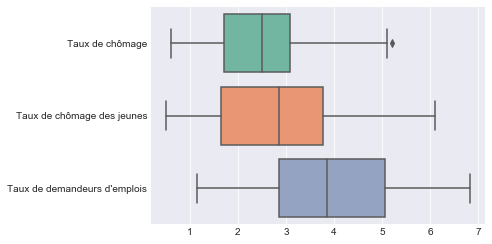

In [16]:
sns.boxplot(data=amstat_unemp_rate[['Taux de chômage','Taux de chômage des jeunes',"Taux de demandeurs d'emplois"]],orient='h',palette="Set2",whis=1.5)
plt.show()

The distribution for the three parameters are more or less symmetric and we can notice an outlier for the Unemployment rate (Taux de chômage).

The goal of this exercise is to see how the choose of metrics to quantify the unemployment rate can lead to different interpretations. Thus, it is better to use the same classification method for the three parameters we will plot in order to avoid an additional "bias" in the vizualisation interpretation.  

That's why we won't choose the natural breaks classification which find an "optimal" classification for a particular dataset. 
An equal interval classification seems to be an interesting choice as the distribution are not very skewed (there won't be a overrepresentation of a class). The quantile interval leads to the approximately the same number of groups in every class and it doesn't seem as a good choice since we have outliers which could be unnoticed.

#### Chloropleth map for the Unemployment rate as it defined by the Swiss Confederation

In [17]:
# Create a folium map centered on the geographical center of Switzerland
amstat_unemp1_map=folium.Map(location=[46.900000, 8.226667],tiles='cartodbpositron',zoom_start=8)

# Add an overlay to the map (TopoJSON associated with the variable of interest)
amstat_unemp1_map.choropleth(
geo_data=swiss_cantons,
data=amstat_unemp_rate,
columns=['Code', 'Taux de chômage'],
key_on='feature.id',
topojson='objects.cantons',
fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.8, line_color='white',
legend_name="Unemployment rate [%] in September 2017",
)

# Save the map in an HTML file
amstat_unemp1_map.save('Swiss_unemployment_rate_1.html')
amstat_unemp1_map

Even if Geneva is the only outlier with an unemployment rate of 5.2%, the canton of Neuchâtel has also an extreme value (5.1%) so the choice of 6 bins for the data classification makes sense as it permites to highlight the cantons with the extreme unemployment rates without overrepresenting a specific class.

#### Chloropleth map for the Unemployment rate considering all the job seekers

In [ ]:
amstat_unemp2_map=folium.Map(location=[46.900000, 8.226667],tiles='cartodbpositron',zoom_start=8)
amstat_unemp2_map.choropleth(
geo_data=swiss_cantons,
data=amstat_unemp_rate,
columns=['Code', "Taux de demandeurs d'emplois"],
key_on='feature.id',
topojson='objects.cantons',
fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.8,line_color='white',
legend_name="Unemployment rate without people having already a job [%] in September 2017"
)
# Save the map in an HTML file
amstat_unemp2_map.save('Swiss_unemployment_rate_2.html')
amstat_unemp2_map

COMMENT

#### Chloropleth map for the Youth unemployment rate

In [ ]:
amstat_unemp_youth_map=folium.Map(location=[46.900000, 8.226667],tiles='cartodbpositron',zoom_start=8)
amstat_unemp_youth_map.choropleth(
geo_data=swiss_cantons,
data=amstat_unemp_rate,
columns=['Code', "Taux de chômage des jeunes"],
key_on='feature.id',
topojson='objects.cantons',
fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.8,line_color='white',
legend_name="Youth (15-24 y/o) unemployment rate [%] in September 2017"
)
# Save the map in an HTML file
amstat_unemp_youth_map.save('Swiss_unemployment_rate_2.html')
amstat_unemp_youth_map

## <font color='purple'>Question 3</font> 
<b>Use the amstat website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between Swiss and foreign workers.

The Economic Secretary (SECO) releases a monthly report on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for foreign (5.1%) and Swiss (2.2%) workers.

Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (hint The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?</b>

First, we gather the rates for both categories in all cantons.

In [18]:
foreigners_vs_swiss = pd.read_csv('amstat_foreigners_vs_swiss.csv',sep=',',skipfooter=1,thousands="'",encoding='utf-16',engine='python')
foreigners_vs_swiss

,Canton,Nationalité,Taux de chômage
0,Zurich,Etrangers,5.3
1,Zurich,Suisses,2.5
2,Berne,Etrangers,5.5
3,Berne,Suisses,1.8
4,Lucerne,Etrangers,3.9
5,Lucerne,Suisses,1.3
6,Uri,Etrangers,2.1
7,Uri,Suisses,0.4
8,Schwyz,Etrangers,3.4
9,Schwyz,Suisses,1.2


Then we handle it in the same fashion as question 2, by linking the canton codes in order.

In [19]:
foreigners_rate = foreigners_vs_swiss[foreigners_vs_swiss["Nationalité"] == "Etrangers"].reset_index().drop(["index"],axis=1)
foreigners_rate = foreigners_rate.merge(cantons_id[['Code']],left_index=True,right_index=True)
swiss_rate = foreigners_vs_swiss[foreigners_vs_swiss["Nationalité"] == "Suisses"].reset_index().drop(["index"],axis=1)
swiss_rate = swiss_rate.merge(cantons_id[['Code']],left_index=True,right_index=True)

Now, we can simply map the rates for both categories :

In [20]:
foreigners_map=folium.Map(location=[46.900000, 8.226667],tiles='cartodbpositron',zoom_start=8)
foreigners_map.choropleth(
geo_data=swiss_cantons,
data=foreigners_rate,
columns=['Code', 'Taux de chômage'],
key_on='feature.id',
topojson='objects.cantons',
fill_color='YlOrRd',
legend_name="Unemployment rate (%) of people of foreign nationality in september 2017"
)
foreigners_map.save("foreigners_map.html")

[Click here for the map](foreigners_map.html)

In [ ]:
swiss_map=folium.Map(location=[46.900000, 8.226667],tiles='cartodbpositron',zoom_start=8)
swiss_map.choropleth(
geo_data=swiss_cantons,
data=swiss_rate,
columns=['Code', 'Taux de chômage'],
key_on='feature.id',
topojson='objects.cantons',
fill_color='YlOrRd',
legend_name="Unemployment rate (%) of people of swiss nationality in september 2017"
)
swiss_map.save("swiss_map.html")

[Click here for the map](swiss_map.html)

The first thing we notice is that the maximum rate for swiss people is about half of the maximum rate for foreigners and the minimum rate for foreigners is near the median of the swiss rates, which is effectively a big discrepancy. It adds up with the general 2-for-1 gap that has been observed on a national level. We can note that all cantons have higher unemployment rates for foreigners that locals.

Besides that, on their respective scales, the rates vary similarly for most cantons, the only big difference being for Bern, which is in the top 50% for foreigners (high unemployment rate, between 6 and 7%) but quite low for swiss people (only between 1.1 and 1.9%). It is only a reinforcement of the trend that we observed and not a counter-example.

<b>Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.</b>


Since there is not way to get the rate for those double criteria categories (nationality and age) from the amstat website, we decided to get the numbers alone and calculate the proportion of each age category for each nationality. 

The most suited visualization tool for multivariate data like this is a stacked bar chart. Using these proportions, we can draw one simply based on the rate for the nationality and divide each bar into the different age groups.

First we read the data gathered from amstat and arrange it in a nice way to get the numbers needed to compute the proportions :

In [21]:
df_age_nationality = pd.read_csv('amstat_age_and_nationality.csv',sep=',',skipfooter=1,thousands="'",encoding='utf-16',engine='python')
df_age_nationality = df_age_nationality.drop([df_age_nationality.columns[2],df_age_nationality.columns[4]],axis=1)
df_age_nationality = df_age_nationality[df_age_nationality["Nationalité"]!="Total"]
df_age_nationality = df_age_nationality.rename(columns={df_age_nationality.columns[2] : "Age"})
df_age_nationality = df_age_nationality.fillna("Total")
df_age_nationality

,Canton,Nationalité,Age,Chômeurs inscrits
0,Zurich,Etrangers,15-24 ans,1015
1,Zurich,Etrangers,25-49 ans,8846
2,Zurich,Etrangers,50 ans et plus,2250
3,Zurich,Etrangers,Total,12111
4,Zurich,Suisses,15-24 ans,2405
5,Zurich,Suisses,25-49 ans,8207
6,Zurich,Suisses,50 ans et plus,4502
7,Zurich,Suisses,Total,15114
9,Berne,Etrangers,15-24 ans,597
10,Berne,Etrangers,25-49 ans,3316


Then, we select the different categories and we compute their proportions :

In [22]:
total_swiss = df_age_nationality[(df_age_nationality["Nationalité"]=="Suisses") & (df_age_nationality["Age"]=="Total")][["Chômeurs inscrits"]].astype(float)
total_foreigners = df_age_nationality[(df_age_nationality["Nationalité"]=="Etrangers") & (df_age_nationality["Age"]=="Total")][["Chômeurs inscrits"]].astype(float)

young_swiss = df_age_nationality[(df_age_nationality["Nationalité"]=="Suisses") & (df_age_nationality["Age"]=="15-24 ans")][["Chômeurs inscrits"]]
young_foreigners = df_age_nationality[(df_age_nationality["Nationalité"]=="Etrangers") & (df_age_nationality["Age"]=="15-24 ans")][["Chômeurs inscrits"]]

middle_swiss = df_age_nationality[(df_age_nationality["Nationalité"]=="Suisses") & (df_age_nationality["Age"]=="25-49 ans")][["Chômeurs inscrits"]]
middle_foreigners = df_age_nationality[(df_age_nationality["Nationalité"]=="Etrangers") & (df_age_nationality["Age"]=="25-49 ans")][["Chômeurs inscrits"]]

old_swiss = df_age_nationality[(df_age_nationality["Nationalité"]=="Suisses") & (df_age_nationality["Age"]=="50 ans et plus")][["Chômeurs inscrits"]]
old_foreigners = df_age_nationality[(df_age_nationality["Nationalité"]=="Etrangers") & (df_age_nationality["Age"]=="50 ans et plus")][["Chômeurs inscrits"]]

In [23]:
#this is from the previous dataframe that contains the rates for each nationality
general_swiss_rate = swiss_rate["Taux de chômage"].values

young_swiss_rate = np.squeeze(young_swiss.values/total_swiss.values)*general_swiss_rate
middle_swiss_rate = np.squeeze(middle_swiss.values/total_swiss.values)*general_swiss_rate
old_swiss_rate = np.squeeze(old_swiss.values/total_swiss.values)*general_swiss_rate

In [24]:
#same thing here
general_foreigners_rate = foreigners_rate["Taux de chômage"].values

young_foreigners_rate = np.squeeze(young_foreigners.values/total_foreigners.values) * general_foreigners_rate
middle_foreigners_rate = np.squeeze(middle_foreigners.values/total_foreigners.values) * general_foreigners_rate
old_foreigners_rate = np.squeeze(old_foreigners.values/total_foreigners.values) * general_foreigners_rate

Finally, we put all of this in a nice stacked bar chart :

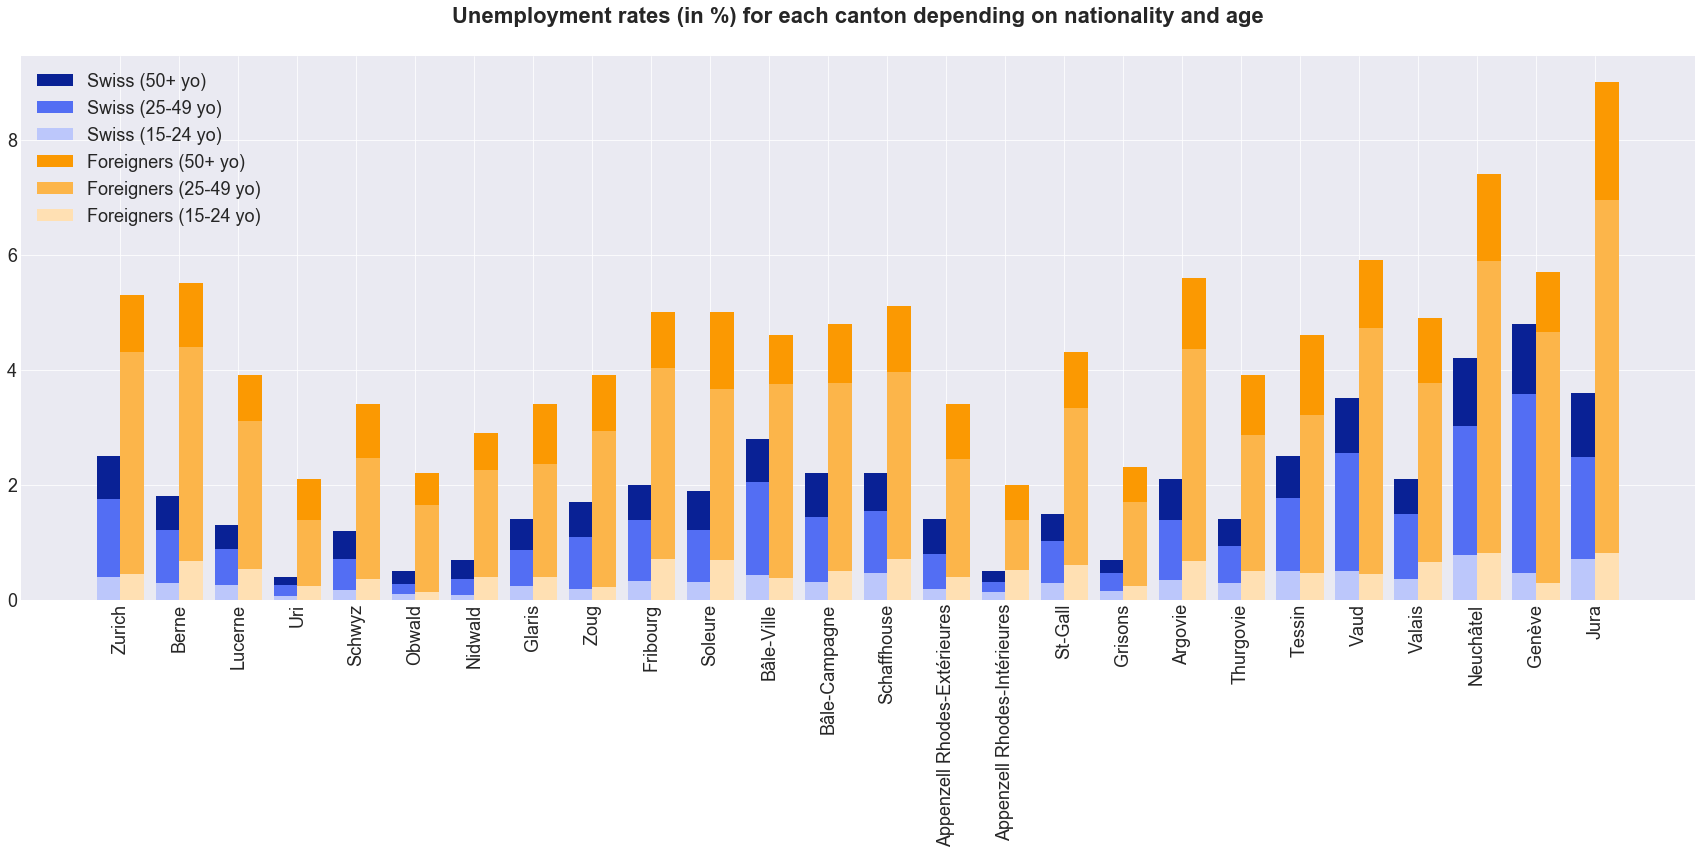

In [25]:
cantons = swiss_rate["Canton"].values
nb_cantons = np.arange(len(cantons))

plt.figure(figsize=(30,10))

b1 = plt.bar(nb_cantons-0.2, young_swiss_rate+middle_swiss_rate+old_swiss_rate, width=0.4, color="#092195", align='center')
b2 = plt.bar(nb_cantons-0.2, young_swiss_rate+middle_swiss_rate, width=0.4, color="#536EF3", align='center')
b3 = plt.bar(nb_cantons-0.2, young_swiss_rate, width=0.4, color="#BCC7FB", align='center')

b4 = plt.bar(nb_cantons+0.2, young_foreigners_rate+middle_foreigners_rate+old_foreigners_rate, width=0.4, color="#FB9902", align='center')
b5 = plt.bar(nb_cantons+0.2, young_foreigners_rate+middle_foreigners_rate, width=0.4, color="#FCB54A", align='center')
b6 = plt.bar(nb_cantons+0.2, young_foreigners_rate, width=0.4, color="#FFE0B3", align='center')

plt.xticks(nb_cantons,cantons,rotation=90,fontsize=18)
plt.yticks(fontsize=18)

lgd = plt.legend([b1,b2,b3,b4,b5,b6],["Swiss (50+ yo)","Swiss (25-49 yo)","Swiss (15-24 yo)","Foreigners (50+ yo)","Foreigners (25-49 yo)","Foreigners (15-24 yo)"],fontsize=18)

ttl = plt.title("Unemployment rates (in %) for each canton depending on nationality and age",fontsize=22,fontweight='bold')
ttl.set_position([.5, 1.05])

plt.savefig("nationality_and_age_rates", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In this graph, the blue bars represent the unemployment rate for locals and the orange bar, for foreigners. We can clearly see here the trend that we observed before on the maps, but we can add that Geneva is the canton where the two rates are the closest (less than 1% gap).

The new information here is that for both locals and foreigners, in all cantons, the 25-49 age range constitutes the biggest part of unemployed people. This makes sense since it is most certainly the biggest part of the active population. Also all the cantons seem to have a very low unemployment rate for young people.